In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import pickle

In [2]:
class EnvWareHouseDet(gym.Env):
    def __init__(self):
        self.grid = 6  # Grid size
        self.observation_space = spaces.Discrete(self.grid * self.grid * 2)  # 6x6 grid + carry status
        self.action_space = spaces.Discrete(4)  # Actions: UP, DOWN, LEFT, RIGHT
        self.max_timestamps = 10  # Maximum number of time steps
        self.rewards = {
            "successful": 100,
            "pickup_first_time": 25,
            "obstacle": -20,
            "step_penalty": -1
        }
        self.obstacles = [(1, 1), (4, 0), (2, 5), (4, 4)]  # Obstacles coordinates
        self.dropoff = [5, 5]  # Drop-off point
        self.pickup = [(5, 4)]  # Pickup point
        self.state = self.reset()  # Initial state


    def reset(self):

        # Initialize agent and environment variables
        self.prev_pos = [5, 0]
        self.carry = False
        self.reward = 0
        self.done = False
        self.timestamps = 0
        self.agent = [5, 0]  # Agent's starting position

        # Initialize the state as a grid with penalties
        self.state = np.full((self.grid, self.grid), self.rewards["step_penalty"])

        # Set obstacles in the grid
        for x, y in self.obstacles:
            self.state[x, y] = self.rewards["obstacle"]

        # Set the agent position and drop-off point
        self.state[tuple(self.agent)] = 1  # Agent's position marked as '1'
        self.state[tuple(self.dropoff)] = self.rewards["successful"]  # Drop-off marked as successful

        # Set the pickup point with a reward for picking it up for the first time
        for pickup in self.pickup:
            self.state[tuple(pickup)] = self.rewards["pickup_first_time"]

        # Observation includes both flattened state and carry status
        return np.concatenate([self.state.flatten(), [self.carry]])

    def step(self, action):
        # Store the previous position
        self.prev_pos = self.agent.copy()
        self.reward = 0

        # Move agent based on action
        if action == 0:  # Move down
            self.agent[0] += 1
        elif action == 1:  # Move up
            self.agent[0] -= 1
        elif action == 2:  # Move right
            self.agent[1] += 1
        elif action == 3:  # Move left
            self.agent[1] -= 1

        # Check boundaries and obstacles
        if not (0 <= self.agent[0] < self.grid and 0 <= self.agent[1] < self.grid) or tuple(self.agent) in self.obstacles:
            self.agent = self.prev_pos  # Revert to previous position if out of bounds or hits an obstacle
            self.reward += self.rewards["obstacle"]

        # Pickup logic (if agent reaches the pickup point and is not carrying)
        elif tuple(self.agent) in self.pickup:
            if not self.carry:  # Pickup if not already carrying
                self.carry = True
                self.pickup.remove(tuple(self.agent))  # Remove the pickup from the list
                self.reward += self.rewards["pickup_first_time"]

        # Dropoff logic (if agent reaches the drop-off point and is carrying)
        elif self.agent == self.dropoff and self.carry:
            self.reward += self.rewards["successful"]
            self.done = True  # Episode ends

        else:
            self.reward += self.rewards["step_penalty"]

        # Update the grid (state) after each step
        self.state = np.full((self.grid, self.grid), self.rewards["step_penalty"])
        for x, y in self.obstacles:
            self.state[x, y] = self.rewards["obstacle"]
        for pickup in self.pickup:
            self.state[pickup] = self.rewards["pickup_first_time"]

        self.state[self.agent[0], self.agent[1]] = 1  # Mark agent's new position

        # Return the next state, reward, and done flag
        next_state = np.concatenate([self.state.flatten(), [self.carry]])  # Include carry status in next state
        return next_state, action, self.reward, self.done


In [3]:
class DQN(nn.Module):
    def __init__(self, input_dimensions, output_dimensions):
        # Initialize nn.Module directly
        nn.Module.__init__(self)
        self.fc1 = nn.Linear(input_dimensions, 256)  # Layer to input to 256
        self.fc2 = nn.Linear(256, 128)  # 256 to 128
        self.fc3 = nn.Linear(128, 64)  # 128 to 64
        self.output = nn.Linear(64, output_dimensions)  # 64 to output

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, state_size)
        x = torch.relu(self.fc1(x))  # Apply activation function for layer 1
        x = torch.relu(self.fc2(x))  # Apply activation function for layer 2
        x = torch.relu(self.fc3(x))  # Apply activation function for layer 3
        return self.output(x)

In [5]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size                                   #No. of actions
        self.memory = deque(maxlen=buffer_size)                          #Memory buffer
        self.batch_size = batch_size                                     #Batch size for
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])                     #Store the experiences for buffer
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        ex = self.experience(state, action, reward, next_state, done)                                     # Append to the experience
        self.memory.append(ex)                                                                           # Append to the memory

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)                                        # Randomly selects the experiece
        device = torch.device("cuda")                                                                      # Use cuda GPU tensor computations

        # Convert each batch of experiences to PyTorch tensors and move them to GPU
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)                                       # length of the memory


In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size                                  #initilize the state_size
        self.action_size = action_size                                #Initilize the action size
        self.seed = random.seed(seed)                                 #Initilize the seed for random generator
        self.lr = lr                                                  #Initilize the learning rate
        self.device = torch.device("cuda")                  #cuda for the cpu utilization

        self.local_qnet = DQN(state_size, action_size).to(self.device)              # Local Qnet for training
        self.target_qnet = DQN(state_size, action_size).to(self.device)              # Target q net for stabilizing training
        self.optimizer = optim.Adam(self.local_qnet.parameters(), self.lr)                          # Optimizers to apply on the local qnetwork

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)               # Reply buffer initilization
        self.time_step = 0

    def save_model(self, filename='dqn_model.pkl'):
        model_states = {
            'local_qnet_state_dict': self.local_qnet.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'time_step': self.time_step
        }                                                                   # saving the state of model by local qnet, target qnet
        with open(filename, 'wb') as f:
            pickle.dump(model_states, f)
        print(f"Model saved to {filename}")

    def load_model(self, filename='dqn_model.pkl'):
        with open(filename, 'rb') as f:
            model_states = pickle.load(f)
        self.local_qnet.load_state_dict(model_states['local_qnet_state_dict'])
        self.optimizer.load_state_dict(model_states['optimizer_state_dict'])
        self.time_step = model_states['time_step']
        print(f"Model loaded from {filename}")

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)                                              # Append to memory

        self.time_step = (self.time_step + 1) % 4                                                            # Update the time step resetting for every 4 steps

        if self.time_step == 0:                       # perform loading and learning every four steps
            if len(self.memory) > 64:                   # check the experiences
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)
    def act(self, state, eps=0.):
        if isinstance(state, tuple):
          state = state[0]  # Extract the actual state if it's wrapped in a tuple
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)           # Load the state as tensor

        self.local_qnet.eval()                                               # Evaluate the qnet
        with torch.no_grad():                                                # Disable gradient calculation
            action_values = self.local_qnet(state_tensor)                   # Get the action from Q net
        self.local_qnet.train()                                              # Enable gradient calculation for training

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)
    def learn(self, experiences, gamma=0.99):

          states = [e.state for e in experiences if e is not None]
          actions = [e.action for e in experiences if e is not None]
          rewards = [e.reward for e in experiences if e is not None]
          next_states = [e.next_state for e in experiences if e is not None]
          dones = [e.done for e in experiences if e is not None]

          #Convert the each unpacked experience to the pytorch tensors
          states = [s[0] if isinstance(s, tuple) else s for s in states]
          states = torch.from_numpy(np.vstack([s.reshape(1, -1) if s.ndim == 1 else s for s in states])).float().to(self.device)
          actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
          rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
          next_states = [ns[0] if isinstance(ns, tuple) else ns for ns in next_states]
          next_states = torch.from_numpy(np.vstack([ns.reshape(1, -1) if ns.ndim == 1 else ns for ns in next_states])).float().to(self.device)  # Corrected to self.device

          dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(self.device)

          # Compute the next Q values by the target Q network
          next_Q_values = self.target_qnet(next_states).detach().max(1)[0].unsqueeze(1)
          target_Q_values = rewards + (gamma * next_Q_values * (1 - dones))                    #Apply the bellman equation

          expected_Q_values = self.local_qnet(states).gather(1, actions)                           #expected q values by the local qnet
          loss = F.mse_loss(expected_Q_values, target_Q_values)                              #Compute loss between expected and target q values
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
          self.soft_update(self.local_qnet, self.target_qnet, tau=1e-3)                       # Soft update the local q network
    def soft_update(self, local_model, target_model, tau):
          for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
              target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [8]:
# Learning Parameters
alpha = 0.0005          # Learning rate (low to ensure stable learning)
gamma = 0.99            # Discount factor (high to prioritize future rewards)
epsilon_start = 1.0     # Initial exploration rate
epsilon_min = 0.05      # Minimum exploration rate
epsilon_decay = 0.9995  # Decay rate for epsilon (gradual decrease)
buffer_size = 100000    # Replay buffer size
batch_size = 64         # Batch size for training
update_frequency = 4    # Frequency of updating the target network
tau = 0.001             # Soft update parameter for target network

# Training Parameters
num_episodes = 5000    # Number of training episodes
max_steps_per_episode = 100  # Max steps per episode
target_update_interval = 1000  # Update target network every X steps

# Optimizer
learning_rate = 0.0005

env = EnvWareHouseDet()
state = env.reset()
input_dim = len(state)  # Use env.observation_space.n here
output_dim = env.action_space.n
agent  = DQNAgent(state_size=input_dim, action_size=output_dim, seed=0, lr=learning_rate)
#initilize the buffer
buffer = ReplayBuffer(action_size=agent.action_size, buffer_size=buffer_size, batch_size=batch_size, seed=42)

In [10]:
# Training loop
import os

os.makedirs("Ware/", exist_ok=True)
epsilon_values = []
total_rewards = []
# Training loop
for episode in range(num_episodes):
    # Reset the environment
    state = env.reset()
    total_reward = 0
    epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode))
    # Run one episode
    for step in range(max_steps_per_episode):
        # Choose and perform an action
        action = agent.act(state, epsilon)
        next_state, action, reward, done = env.step(action)
        total_reward += reward

        # Store the experience in the replay buffer
        buffer.add(state, action, reward, next_state, done)

        if len(buffer) >= batch_size:
            batch = random.sample(buffer.memory, batch_size)
            # Update the agent's knowledge
            agent.learn(batch, gamma)

        state = next_state
        epsilon_values.append(epsilon)
        total_rewards.append(total_reward)
        # Check if the episode has ended
        if done:
            break


    # Periodically print the progress of training
    if (episode + 1) % 100 == 0:  # Print every 100 episodes
        print(f"Episode {episode + 1}/{num_episodes}: Epsilon {epsilon:.4f}")
agent.save_model(f"Ware/dqn_ware_final.pkl")

Episode 100/5000: Epsilon 0.9517
Episode 200/5000: Epsilon 0.9053
Episode 300/5000: Epsilon 0.8611
Episode 400/5000: Epsilon 0.8191
Episode 500/5000: Epsilon 0.7791
Episode 600/5000: Epsilon 0.7411
Episode 700/5000: Epsilon 0.7050
Episode 800/5000: Epsilon 0.6706
Episode 900/5000: Epsilon 0.6379
Episode 1000/5000: Epsilon 0.6068
Episode 1100/5000: Epsilon 0.5772
Episode 1200/5000: Epsilon 0.5490
Episode 1300/5000: Epsilon 0.5222
Episode 1400/5000: Epsilon 0.4967
Episode 1500/5000: Epsilon 0.4725
Episode 1600/5000: Epsilon 0.4495
Episode 1700/5000: Epsilon 0.4275
Episode 1800/5000: Epsilon 0.4067
Episode 1900/5000: Epsilon 0.3868
Episode 2000/5000: Epsilon 0.3680
Episode 2100/5000: Epsilon 0.3500
Episode 2200/5000: Epsilon 0.3329
Episode 2300/5000: Epsilon 0.3167
Episode 2400/5000: Epsilon 0.3013
Episode 2500/5000: Epsilon 0.2866
Episode 2600/5000: Epsilon 0.2726
Episode 2700/5000: Epsilon 0.2593
Episode 2800/5000: Epsilon 0.2466
Episode 2900/5000: Epsilon 0.2346
Episode 3000/5000: Epsi

In [16]:
len(epsilon_values)

5000

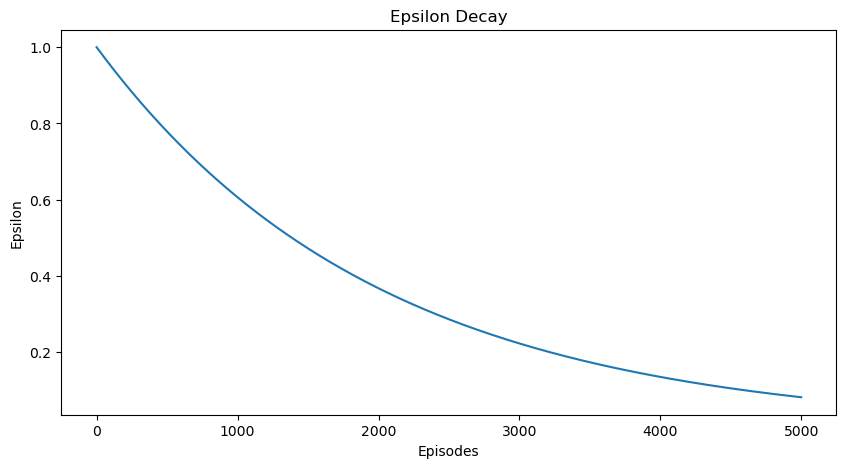

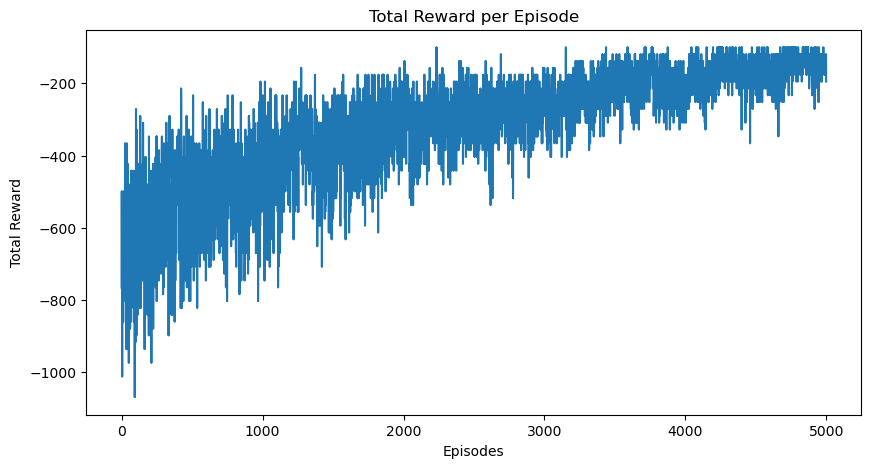

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(epsilon_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.show()

# Plot Total Rewards per Episode
plt.figure(figsize=(10, 5))
plt.plot(total_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


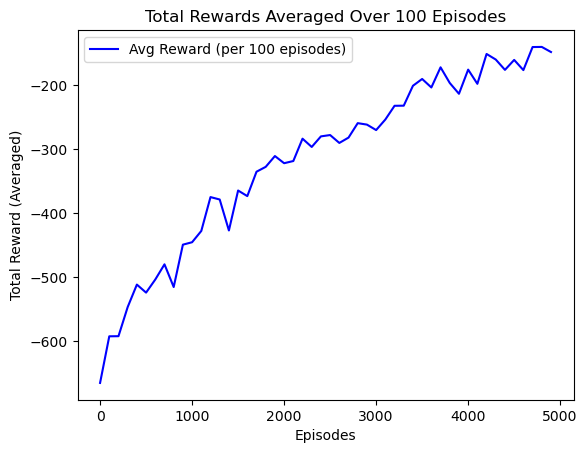

In [19]:
smoothed_rewards = np.mean(np.array(total_rewards).reshape(-1, 100), axis=1)

# Plot the averaged rewards
plt.plot(range(0, len(total_rewards), 100), smoothed_rewards, label="Avg Reward (per 100 episodes)", color='blue')

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Averaged)")
plt.title("Total Rewards Averaged Over 100 Episodes")
plt.legend()
plt.show()

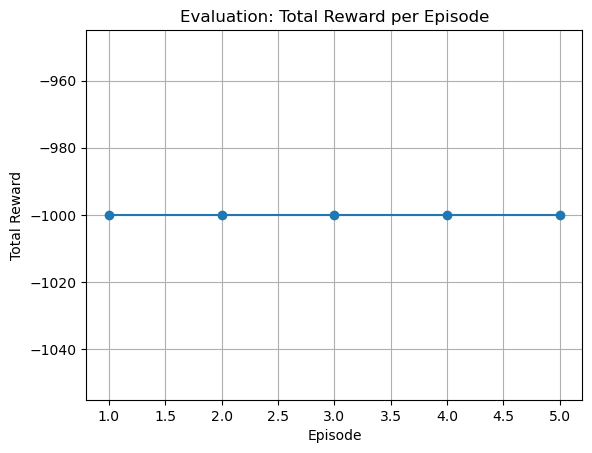

In [29]:
model_filename = "Ware/dqn_ware_final.pkl"
with open(model_filename, 'rb') as f:
    model_states = pickle.load(f)

# Assuming n_agent is already defined and initialized elsewhere
agent.local_qnet.load_state_dict(model_states['local_qnet_state_dict'])
agent.optimizer.load_state_dict(model_states['optimizer_state_dict'])
agent.time_step = model_states['time_step']

# Move the model to CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    agent.local_qnet.to(device)
else:
    device = torch.device("cpu")

# Initialize the CartPole environment
env = EnvWareHouseDet()

# Evaluate the agent for 5 episodes, using only greedy actions
total_rewards = []
max_steps = 50
for episode in range(5):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done and steps < max_steps:
        # Convert state to tensor for the model input
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device) # Move to device

        # Get action using the greedy policy (no exploration)
        with torch.no_grad():
            action = agent.local_qnet(state_tensor).argmax().item()

        # Take action in the environment
        state, action, reward, done = env.step(action)

        total_reward += reward
        steps += 1
    total_rewards.append(total_reward)

# Plot total rewards per episode
plt.plot(range(1, 6), total_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Evaluation: Total Reward per Episode')
plt.grid(True)
plt.show()

In [30]:
len(total_rewards)

5